# 第12章 連続時間カルマンフィルタ

In [6]:
import numpy as np
from scipy.integrate import ode
from plot_filtering_test import * #実行フォルダに plot_filtering_test.py を置いてインポートします．

#### 乱数シードの指定（テキスト掲載用）
拙著に掲載の標本路を再現するため，シードを明示しておきます．本来は必要ないので，コメントアウトしてもいいです．

In [7]:
np.random.seed(123)

## クラスと関数

### 算法12.2 （Kalman-Bucyフィルタ）

In [8]:
from class_ssKBF import * #実行フォルダに class_ssKBF.py を置いてインポートします． 

In [9]:
# 内容の確認
for line in open('./class_ssKBF.py'): print(line[:-1])

import numpy as np
from scipy.integrate import ode
from scipy.linalg import solve_continuous_are

class class_ssKBF: # Steady-state Kalman-Bucy filter

    def __init__(s, A, D, C, Q, R, x0, cov0=None, CL=None, t0=0.0):
        
        ### システム行列
        s.A = np.array(A) #状態行列
        s.D = np.array(D) #駆動行列
        s.C = np.array(C) #観測行列
        # 雑音
        s.Q = np.array(Q) #システム雑音の共分散
        s.R = np.array(R) #観測雑音の共分散
        
        ### システムのサイズ
        s.xdim   = A.shape[1]   #状態の次元＝Aの列数
        s.ydim   = C.shape[0]   #観測の次元＝Cの行数
        s.covdim = s.xdim**2 #本来は三角成分だけでよいが手抜き

        ### LQG制御用の閉ループ行列(デフォルトはA)
        if CL is None:
            s.CL = s.A
        else:
            s.CL = CL.copy()
        
        ### KBFの初期値
        s.t    = 0.0
        s.xf   = np.array(x0) #濾波推定値
        s.cov0 = cov0         #共分散行列
        s.K    = None         #カルマンゲイン

        ### 定常カルマンフィルタの導出
        RicA = s.A.T
        RicB = s.C.T
        RicQ = s.D.dot(s.Q).dot(s.D.T)
        

### 標本路の取得（線形一般，連続時間）

In [10]:
from class_LinearSDE import * #実行フォルダに class_LinearSDE.py を置いてインポートします． 

In [11]:
# 内容の確認
#for line in open('./class_LinearSDE.py'): print(line[:-1])

## 12.4 数値例

In [12]:
class Vib1DOF_CT: # 1自由度振動系，連続時間
    
    def __init__(self, c=0.3, k=1.0, Δt=0.1, Qval=1e-8, Rval=0.1 ):
        ### システムの定義
        # 状態行列
        self.A = np.array([[0,1],[-k,-c]])
        # 駆動行列
        self.D = np.array([[0],[1]]) #縦ベクトル 
        # 観測行列：1行2列と仮定
        self.C = np.array([[0,1]])
        # ノイズの条件
        self.Q = np.array([[Qval]]) #スカラは1x1行列として与える
        self.R = np.array([[Rval]]) #同上
        ### 出力データ
        self.tt = None   # 時刻の列
        self.xx = None   # 状態量の時系列
        self.yy = None   # 観測量の時系列
        self.xxf = None  # 濾波推定値の時系列
        self.xxni = None # 数値積分推定値の時系列
        ### その他
        self.Δt = Δt   # 数値積分の時間ステップ
        
    ### 標本路の取得
    def get_sample_path(s, x0=[1,0], tn=200):
        # 初期値とデータ長
        s.x0 = np.array(x0)
        s.tn = tn
        sde = class_LinearSDE(s.A, s.D, s.C, s.Q, s.R, s.x0, s.Δt)
        s.tt, s.xx, s.yy = sde.get_sample_path(tn)
        
    ### 濾波推定（定常カルマンフィルタ）
    def do_filtering(s):
        x0 = s.x0
        cov0 = None
        kbf = class_ssKBF(s.A, s.D, s.C, s.Q, s.R, x0)
        s.xxf = np.zeros((s.tn+1,2))
        for t, yt in enumerate(s.yy):
            s.xxf[t,:] = kbf.xf
            kbf.filtering(yt,s.Δt)
        # フィルタの安定性の確認    
        kbf.stability() 

    ### 数値積分による推定
    def do_NI_estimation(self):
        self.xxni = np.zeros((self.tn+1,2))
        xni = self.x0[0]
        for t, yt in enumerate(self.yy):
            self.xxni[t,0] = xni #観測された速度の数値積分値
            self.xxni[t,1] = yt  #観測された速度そのもの
            xni += yt*self.Δt

### 数値積分推定との比較

Steady-state Kalman gain =
 [[1.80382125e-17]
 [2.38516481e-01]]
This filter is stable
> Eigenvalues:
> (-0.26925824035672397+0.9630680142129117j)
> (-0.26925824035672397-0.9630680142129117j)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


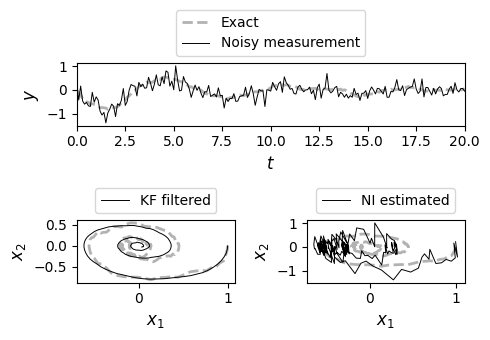

In [13]:
# システム雑音 + 観測雑音
vib1 = Vib1DOF_CT(Qval=0.01, Rval=0.05)
vib1.get_sample_path(tn=200)
vib1.do_filtering()
vib1.do_NI_estimation()
plot_filtering_test(vib1)
plt.savefig('figs/Ch12-Q1R1.eps', bbox_inches='tight')

Steady-state Kalman gain =
 [[0.]
 [0.]]
This filter is stable
> Eigenvalues:
> (-0.15+0.9886859966642595j)
> (-0.15-0.9886859966642595j)


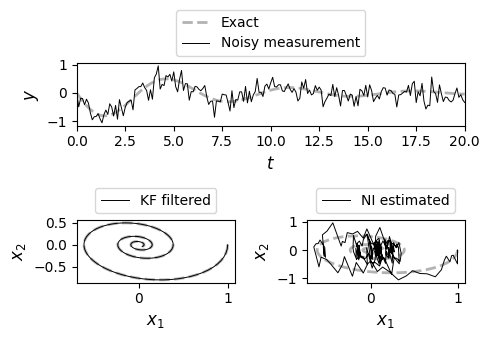

In [14]:
# システム雑音なし + 観測雑音
vib1 = Vib1DOF_CT(Qval=0, Rval=0.05)
vib1.get_sample_path(tn=200)
vib1.do_filtering()
vib1.do_NI_estimation()
plot_filtering_test(vib1)

Steady-state Kalman gain =
 [[2.19243084e-12]
 [3.13241996e+01]]
This filter is stable
> Eigenvalues:
> -0.031653035570560206
> -31.592546559038144


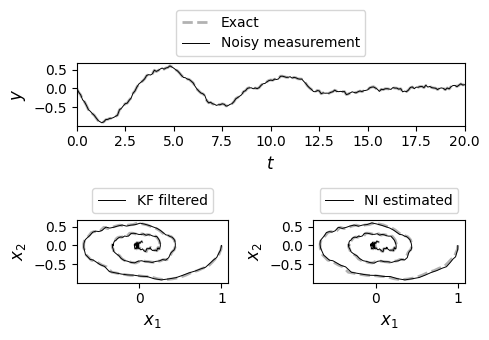

In [15]:
# システム雑音 + 観測雑音なし
vib1 = Vib1DOF_CT(Qval=0.01, Rval=1e-5)
vib1.get_sample_path(tn=200)
vib1.do_filtering()
vib1.do_NI_estimation()
plot_filtering_test(vib1)